In [ ]:
!apt-get update
!pip install music21
!apt-get -y install lilypond

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,284 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,158 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,264 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
#Loading the list of  midi files as stream
filepath = "/content/drive/MyDrive/music midi files dataset for research/musicnet_midis/Brahms/"
import os
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

#this will take time to load

print(all_midis)

[<music21.stream.Score 0x7cae71f0f400>, <music21.stream.Score 0x7cae6843ca00>, <music21.stream.Score 0x7cae71f0dea0>, <music21.stream.Score 0x7cae602c90f0>, <music21.stream.Score 0x7cae603e0a00>, <music21.stream.Score 0x7cae7179add0>, <music21.stream.Score 0x7cae7179aec0>, <music21.stream.Score 0x7cae7179b0d0>, <music21.stream.Score 0x7cae770ec6a0>, <music21.stream.Score 0x7cae723681f0>, <music21.stream.Score 0x7cae71bd62c0>, <music21.stream.Score 0x7cae7ab2ca00>, <music21.stream.Score 0x7cae747d06a0>, <music21.stream.Score 0x7cae82aa9ff0>, <music21.stream.Score 0x7cae87a36cb0>, <music21.stream.Score 0x7cae8c8196c0>, <music21.stream.Score 0x7cae8c8ed090>, <music21.stream.Score 0x7cae70812bf0>, <music21.stream.Score 0x7cae75dc3fd0>, <music21.stream.Score 0x7cae70a9ee00>, <music21.stream.Score 0x7cae6b6a10f0>, <music21.stream.Score 0x7cae7e988fa0>, <music21.stream.Score 0x7cae85d603d0>, <music21.stream.Score 0x7cae6b3c7a60>]


In [ ]:
len(all_midis)

24

In [ ]:
#function defination to get the notes.

def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the midi", len(Corpus))
print("Notes of the MIDI file",Corpus[:10])
print("Now as you see we have our music notes/chords in the corpus format.")

Total notes in all the midi 115669
Notes of the MIDI file ['G4', 'B4', 'C5', 'C4', 'G4', 'B4', 'C5', 'C4', 'B4', 'E5']
Now as you see we have our music notes/chords in the corpus format.


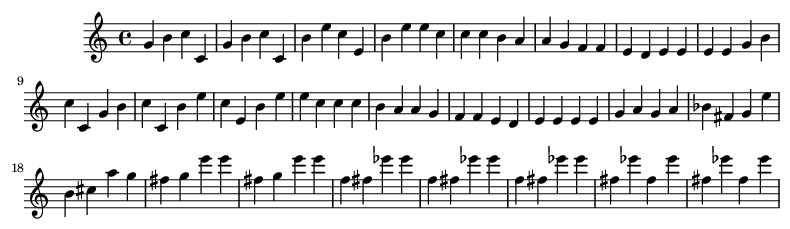

In [ ]:
def show(music):
    display(Image(str(music.write("lily.png"))))


def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = []
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else:
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

In [ ]:
#Kaggle currently dont support MIDI files
#Convert the MIDI files into wav format to play the sample audio
print("Sample Audio From Data")
IPython.display.Audio("/content/drive/MyDrive/music midi files dataset for research/Output/haydn/2104_op64n5_1.mp3")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))
print(count_num)

Total unique notes in the Corpus: 331
Counter({'D4': 4116, 'G4': 3932, 'D5': 3432, 'F4': 3329, 'A4': 3312, 'C4': 3032, 'G3': 3015, 'C5': 2977, 'A3': 2851, 'E4': 2738, 'B-4': 2683, 'E-4': 2576, 'B-3': 2490, 'F#4': 2315, 'G5': 2254, 'D3': 2214, 'F3': 2204, 'E5': 2171, 'B4': 2106, 'F5': 2029, 'G#4': 2019, 'B3': 1899, 'C#4': 1824, 'E-5': 1789, 'C3': 1762, 'G2': 1634, 'A5': 1582, 'E3': 1485, 'C#5': 1470, 'F#3': 1383, 'B-2': 1382, 'G#3': 1377, 'F#5': 1291, 'E-3': 1266, 'A2': 1261, 'F2': 1226, 'B-5': 1082, 'C2': 1024, 'B2': 1022, 'C6': 982, 'D6': 912, 'G#5': 883, '7': 873, '0': 847, 'C#3': 821, 'B5': 753, '2': 739, '10': 728, 'D2': 695, 'E-2': 683, '3': 652, '5': 620, 'G#2': 603, 'F#2': 594, 'E2': 543, '9': 504, '4': 461, '4.7': 445, '11': 438, 'E6': 435, '7.10': 432, '8': 420, '3.7': 404, 'E-6': 390, '1': 390, '2.5': 382, '2.7': 379, '0.4': 378, '6': 368, '5.8': 362, 'G6': 357, 'F6': 355, '0.3': 351, '10.2': 346, '9.2': 344, '9.0': 338, '6.9': 320, '5.9': 319, '7.0': 319, '11.2': 310, 'C#6':

In [ ]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 349.4531722054381
Most frequent note in Corpus appeared: 4116 times
Least frequent note in Corpus appeared: 1 time


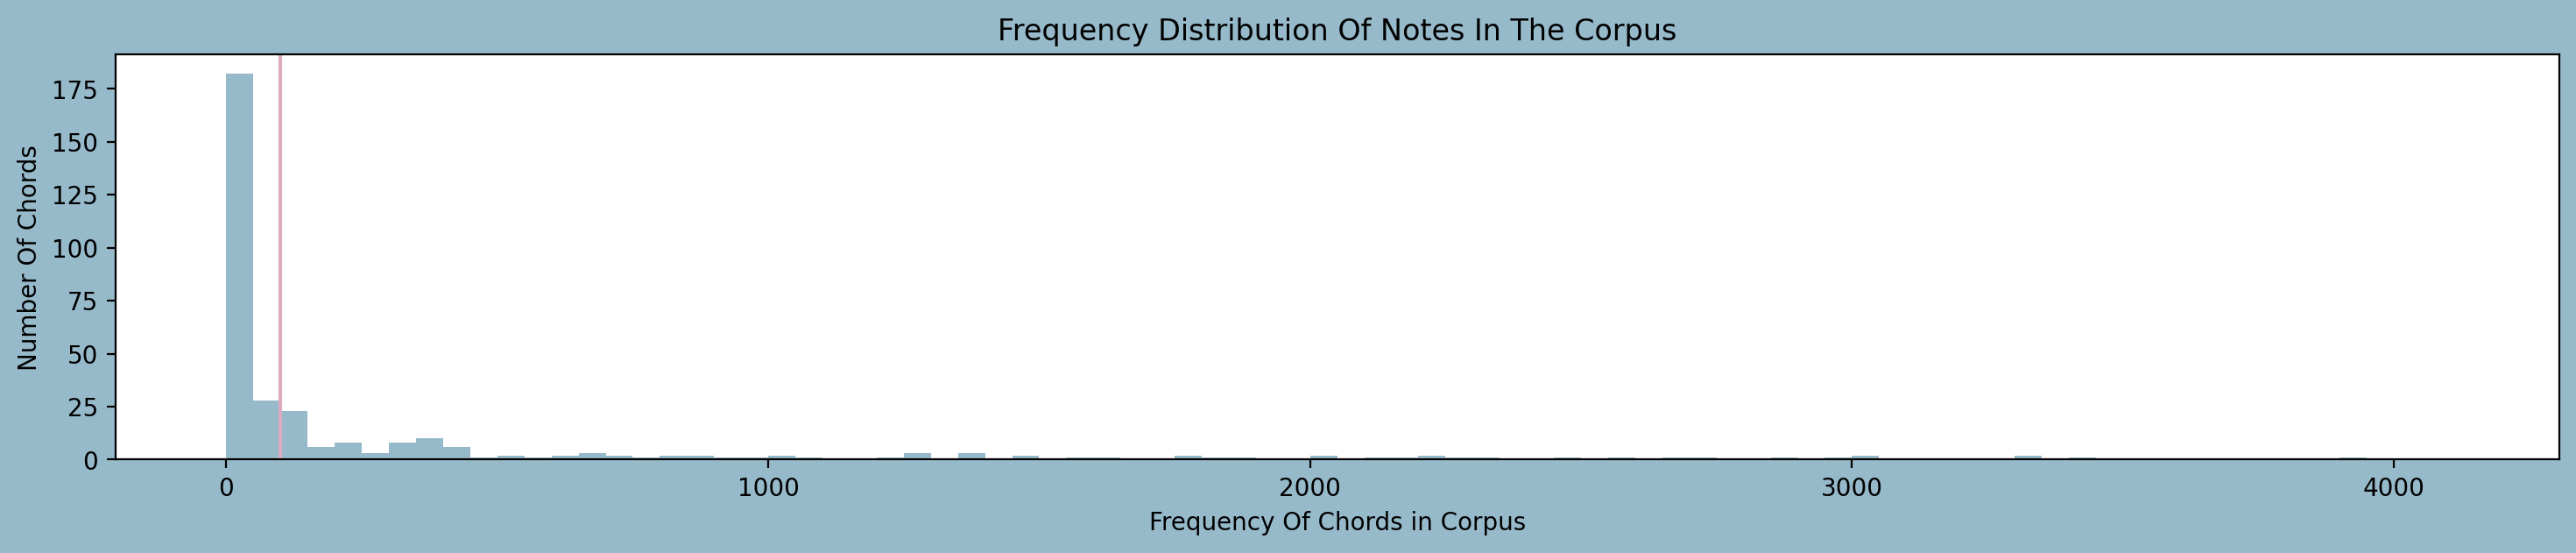

In [ ]:
# Plotting the distribution of Notes to understand the rate notes or in other words anomalies
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords that are occured less than 100 times
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 210


In [ ]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 112517


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to map the notes and their indices and vice versa to retreive the values during predict
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

print("Mapping Values",mapping)
print("Reverse Mapping Values", reverse_mapping)


Total number of characters: 112517
Number of unique characters: 249
Mapping Values {'0': 0, '0.1': 1, '0.1.5.8': 2, '0.2': 3, '0.2.5': 4, '0.2.5.8': 5, '0.2.6': 6, '0.2.7': 7, '0.3': 8, '0.3.5': 9, '0.3.6': 10, '0.3.6.8': 11, '0.3.6.9': 12, '0.3.7': 13, '0.4': 14, '0.4.5': 15, '0.4.5.7': 16, '0.4.6': 17, '0.4.7': 18, '0.4.8': 19, '0.5': 20, '0.6': 21, '1': 22, '1.2': 23, '1.2.4.7': 24, '1.3': 25, '1.3.7': 26, '1.4': 27, '1.4.5.7.9': 28, '1.4.5.8': 29, '1.4.7': 30, '1.4.8': 31, '1.5': 32, '1.5.8': 33, '1.6': 34, '1.7': 35, '10': 36, '10.0': 37, '10.0.2.5.7': 38, '10.0.3.4': 39, '10.0.3.6': 40, '10.0.4': 41, '10.1': 42, '10.1.4': 43, '10.1.5': 44, '10.11': 45, '10.2': 46, '10.2.5': 47, '10.3': 48, '11': 49, '11.0': 50, '11.0.2.5.7': 51, '11.1': 52, '11.1.2': 53, '11.1.4.5': 54, '11.2': 55, '11.2.4.5': 56, '11.2.5': 57, '11.2.5.7': 58, '11.2.6': 59, '11.3': 60, '11.3.5': 61, '11.3.6': 62, '11.4': 63, '2': 64, '2.3': 65, '2.3.6': 66, '2.4': 67, '2.4.8': 68, '2.5': 69, '2.5.7': 70, '2.5.8':

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)
print("Target values preview~", targets[:10])
print("Feature values preview~", features[1])

Total number of sequences in the Corpus: 112477
Target values preview~ [205, 222, 192, 223, 223, 205, 205, 205, 192, 180]
Feature values preview~ [192, 205, 204, 246, 192, 205, 204, 192, 223, 205, 222, 192, 223, 223, 205, 205, 205, 192, 180, 180, 246, 234, 234, 222, 210, 222, 222, 222, 222, 246, 192, 205, 204, 246, 192, 205, 204, 192, 223, 205]


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

print("Shape of the X is{} and Y is{} ".format(X.shape,y.shape))

Shape of the X is(112477, 40, 1) and Y is(112477, 249) 


In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

Model building


In [ ]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)


In [ ]:
#Model's Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 249)               3

In [ ]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=200)

Epoch 1/200
352/352 [==============================] - 24s 41ms/step - loss: 4.4292
Epoch 2/200
352/352 [==============================] - 15s 43ms/step - loss: 4.3794
Epoch 3/200
352/352 [==============================] - 15s 42ms/step - loss: 4.3720
Epoch 4/200
352/352 [==============================] - 15s 43ms/step - loss: 4.3685
Epoch 5/200
352/352 [==============================] - 15s 44ms/step - loss: 4.3657
Epoch 6/200
352/352 [==============================] - 16s 46ms/step - loss: 4.3125
Epoch 7/200
352/352 [==============================] - 16s 45ms/step - loss: 4.3007
Epoch 8/200
352/352 [==============================] - 16s 45ms/step - loss: 4.2956
Epoch 9/200
352/352 [==============================] - 16s 44ms/step - loss: 4.2889
Epoch 10/200
352/352 [==============================] - 16s 44ms/step - loss: 4.2036
Epoch 11/200
352/352 [==============================] - 16s 45ms/step - loss: 4.1582
Epoch 12/200
352/352 [==============================] - 16s 45ms/step - lo

[Text(0.5, 0, 'Epochs')]

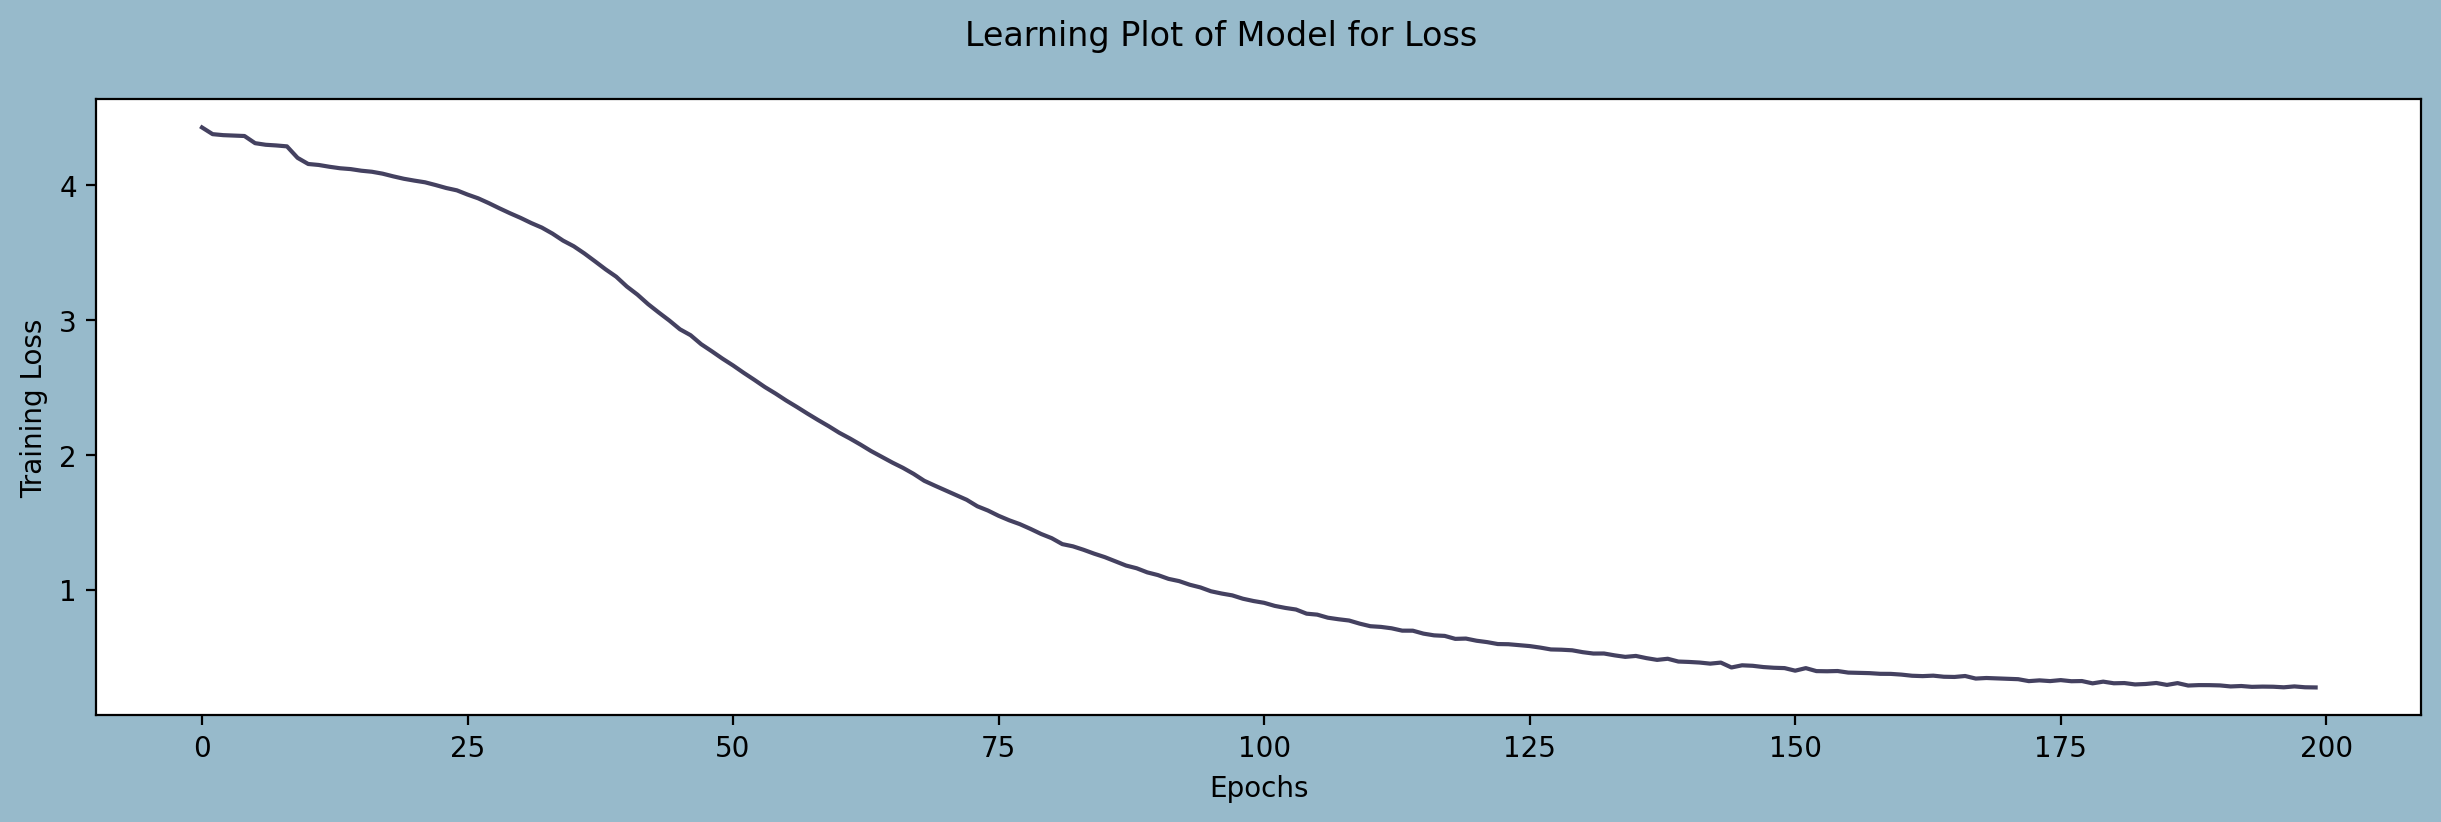

In [ ]:
#Plotting the learnings against loss
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

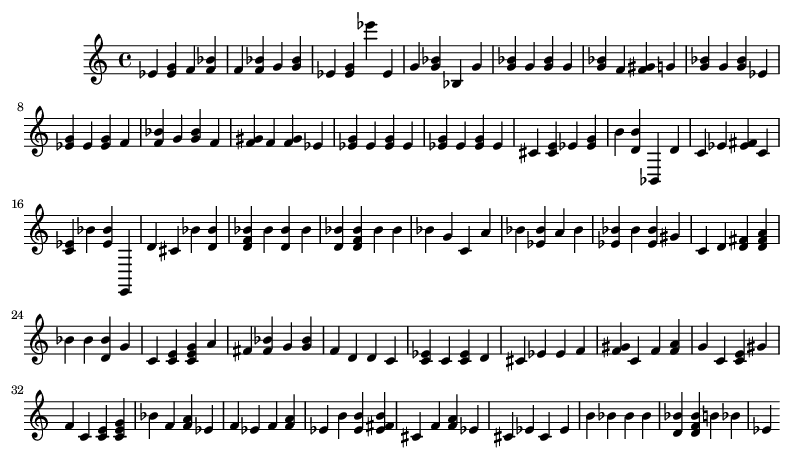

Music Notes of the above  ['3.7', '5.10', '5.10', '7.10', '3.7', 'E-6', 'E-4', '7.10', 'B-3', '7.10', '7.10', '7.10', '5.8', '7.10', '7.10', '3.7', '3.7', '5.10', '7.10', '5.8', '5.8', '3.7', '3.7', '3.7', '3.7', '3', '1.4', '3.7', '11.2', 'B-2', 'D4', 'C4', '3.6', '0.3', '10.3', 'E2', '2', '1', '10.2.5', '10.2', '10.2.5', '10', '10', '10', '7', '0', '9', '10.3', '9', '10.3', '10.3', '8', '0', '2.6.9', '10', '10.2', '7', '0.4.7', '9', '6.10', '7.10', '5', '2', '2', '0.3', '0.3', '2', '1', '3', '3', '5.8', '0', '5.9', '7', '0.4', '8', '5', '0.4.7', '10', '5.9', '3', '5', '3', '5.9', '3', '11.3.6', '1', '5.9', '3', '1', '3', '1', '3', '11', '10', '10', '10.2.5', '11', '10', '3']


In [ ]:
#function defination to generate/predict new lyrics/music in the mid format

def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) /
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]

    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)
    return Music,Melody_midi



Music_notes, Melody = Malody_Generator(100)
show(Melody)
print("Music Notes of the above ",Music_notes)


In [ ]:
#To save the generated melody
Melody.write('midi','newly_generated_music_notes.mid')
#check the output folder for the file


'newly_generated_music_notes.mid'

In [ ]:
#Convert the mid format file to wav, .mp3
#using https://audio.online-convert.com/convert/mid-to-mp3
#to play audio or corpus
IPython.display.Audio("/content/drive/MyDrive/music midi files dataset for research/Output/newly_generated_music_notes.mp3")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
